# This work is based on a training course from freeCodeCamp.org : https://www.youtube.com/watch?v=9Y3yaoi9rUQ

# Intraday Strategy Using GARCH Model  

Using simulated daily data and intraday 5-min data  

Load daily and 5-minute data  

Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window  

Calculate prediction premium and form a daily signal from it  

Merge with intraday data and calculate intraday indicators to form the intraday signal  

Generate the position entry and hold until the end of the day  

Calculate final strategy returns

#  
# 1. Load Simulated Daily and Simulated 5-minute data.  

We are loading both datasets, set the indexes and calculate daily log returns 

In [2]:
# !pip install arch

  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/24/b4/41ffe91f46eb3f49bf022c66f8768f469617329718d4246953ad3853c073/arch-6.3.0-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/924.1 kB ? eta -:--:--
   - ------------------------------------- 41.0/924.1 kB 653.6 kB/s eta 0:00:02
   --- ----------------------------------- 71.7/924.1 kB 787.7 kB/s eta 0:00:02
   ----- -------------------------------- 122.9/924.1 kB 901.1 kB/s eta 0:00:01
   ----- -------------------------------- 143.4/924.1 kB 944.1 kB/s eta 0:00:01
   ------- ------------------------------ 174.1/924.1 kB 871.5 kB/s eta 0:00:01
   --------- ---------------------------- 225.3/924.1 kB 860.2 kB/s eta 0:00:01
   --------- ---------------------------- 235.5/924.1 kB 846.9 kB/s eta 0:00:01
   ---------- --------------------------- 256.0/924.1 kB 785.2 kB/s eta 0:00:01
   ----------- -------------------------- 286.7/924.1 kB 737.3 kB/s eta 0:00:01
   ----

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from arch import arch_model
# from tqdm import tqdm
import pandas_ta
import pandas as pd
import numpy as np
import os

data_folder = 'C:/Users/saika/Downloads/Python_files/Quant_Strategies/Intraday_Simulated_Data'

daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

daily_df

,Date,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7
0,9/17/2014,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN
1,9/18/2014,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,NaN
2,9/19/2014,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,NaN
3,9/20/2014,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,NaN
4,9/21/2014,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,NaN
...,...,...,...,...,...,...,...,...
3284,9/14/2023,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN
3285,9/15/2023,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN
3286,9/16/2023,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN
3287,9/17/2023,6641.981934,6654.499512,6611.268555,6633.546875,6633.546875,6.774211e+09,NaN


In [2]:
daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')

daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log_ret
Date,,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,NaN,-0.074643
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,NaN,-0.072402
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,NaN,0.035111
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,NaN,-0.024968
...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN,0.011801
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN,0.002597
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN,-0.001520


In [3]:
daily_df = daily_df.drop(columns='Unnamed: 7')

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret
Date,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,-0.074643
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,-0.072402
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,0.035111
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,-0.024968
...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520


In [2]:
# Accumulating all the codes for the daily_df part

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')

daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df = daily_df.drop(columns='Unnamed: 7')

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret
Date,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,-0.074643
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,-0.072402
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,0.035111
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,-0.024968
...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520


In [4]:
intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

intraday_5min_df

,datetime,open,low,high,close,volume,Unnamed: 6
0,9/29/2021 20:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN
1,9/29/2021 20:05,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN
2,9/29/2021 20:10,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN
3,9/29/2021 20:15,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN
4,9/29/2021 20:20,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN
...,...,...,...,...,...,...,...
177872,9/20/2023 10:40,6792.1025,6783.6000,6796.2500,6790.1375,41,NaN
177873,9/20/2023 10:45,6790.5575,6779.1000,6795.7500,6781.9175,42,NaN
177874,9/20/2023 10:50,6781.5475,6779.3750,6790.2500,6783.9050,44,NaN
177875,9/20/2023 10:55,6783.9025,6779.9000,6793.2500,6782.0900,95,NaN


In [5]:
intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df

,open,low,high,close,volume,Unnamed: 6
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,NaN
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,NaN
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,NaN


In [6]:
intraday_5min_df = intraday_5min_df.drop(columns='Unnamed: 6')

intraday_5min_df

,open,low,high,close,volume
datetime,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65
...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44


In [40]:
# intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df['datetime'])

pd.to_datetime(pd.to_datetime(intraday_5min_df.reset_index('datetime')['datetime']).dt.date)

# intraday_5min_df

# intraday_5min_df.reset_index('datetime').dt.date

0        2021-09-29
1        2021-09-29
2        2021-09-29
3        2021-09-29
4        2021-09-29
            ...    
177872   2023-09-20
177873   2023-09-20
177874   2023-09-20
177875   2023-09-20
177876   2023-09-20
Name: datetime, Length: 177877, dtype: datetime64[ns]

In [48]:
# To create a date column

# intraday_5min_df = intraday_5min_df.drop(columns='date')

# intraday_5min_df['date'] = np.nan

# intraday_5min_df['date'] = pd.to_datetime(pd.to_datetime(intraday_5min_df.reset_index('datetime')['datetime']).dt.date)

intraday_5min_df['date'] = intraday_5min_df.index.date

intraday_5min_df

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


In [49]:
intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df['date'])

intraday_5min_df

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


In [3]:
# Accumulating all the codes for the intraday_5_min_df part

intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df = intraday_5min_df.drop(columns='Unnamed: 6')

intraday_5min_df['date'] = intraday_5min_df.index.date

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df['date'])

intraday_5min_df

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


# 2. Define the function to fit GARCH model and predict 1-day ahead volatility in a rolling window  

We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance

  
  
After doing a few calculations for optimization of the GARCH model (brute forcing to fit 16 models with a combination for the auto-regressive and moving average orders from {1,2,3,4}, then extracted the mean squared error and the bayesian information criterion and chose the best model to be the one which is minimizing the bayesian information criterion) the instructor found that the best GARCH model on this data is having auto-regressive order of p=1 and moving average order of q=3

In [4]:
# Calculating the rolling 6-month variance

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance
Date,,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,-0.074643,NaN
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,-0.072402,NaN
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,0.035111,NaN
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,-0.024968,NaN
...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384


<Axes: xlabel='Date'>

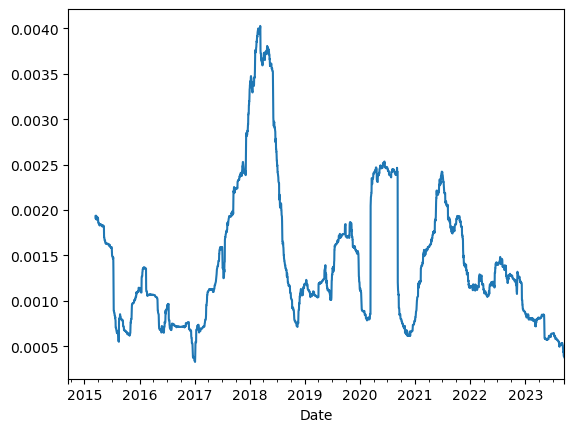

In [5]:
daily_df['variance'].plot()

In [6]:
# Filter the data to be from 2020 onwards

daily_df = daily_df['2020-01-01':]

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance
Date,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,0.000914,0.001125
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,-0.030273,0.001127
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,0.050172,0.001139
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,0.008915,0.001110
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,0.000089,0.001106
...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384


In [7]:
# Creating a function to predict the volatility for everyday i.e. predict the variance for our asset for everyday in a 
# 6-month rolling window

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5, disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    
    print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

# daily_df

C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002459. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2020-06-28 00:00:00
2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002422. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00242. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScale

2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-17 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002377. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2020-07-25 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002347. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00
2020-08-08 00:00:00
2020-08-09 00:00:00
2020-08-10 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00
2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00
2020-08-17 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00
2020-08-20 00:00:00
2020-08-21 00:00:00
2020-08-22 00:00:00
2020-08-23 00:00:00
2020-08-24 00:00:00
2020-08-25 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002434. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2020-08-29 00:00:00
2020-08-30 00:00:00
2020-08-31 00:00:00
2020-09-01 00:00:00
2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00
2020-09-05 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00238. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002379. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScale

2020-09-06 00:00:00
2020-09-07 00:00:00
2020-09-08 00:00:00
2020-09-09 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-12 00:00:00
2020-09-13 00:00:00
2020-09-14 00:00:00
2020-09-15 00:00:00
2020-09-16 00:00:00
2020-09-17 00:00:00
2020-09-18 00:00:00
2020-09-19 00:00:00
2020-09-20 00:00:00
2020-09-21 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002408. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2020-09-22 00:00:00
2020-09-23 00:00:00
2020-09-24 00:00:00
2020-09-25 00:00:00
2020-09-26 00:00:00
2020-09-27 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00
2020-09-30 00:00:00
2020-10-01 00:00:00
2020-10-02 00:00:00
2020-10-03 00:00:00
2020-10-04 00:00:00
2020-10-05 00:00:00
2020-10-06 00:00:00
2020-10-07 00:00:00
2020-10-08 00:00:00
2020-10-09 00:00:00
2020-10-10 00:00:00
2020-10-11 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008472. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008508. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2020-10-12 00:00:00
2020-10-13 00:00:00
2020-10-14 00:00:00
2020-10-15 00:00:00
2020-10-16 00:00:00
2020-10-17 00:00:00
2020-10-18 00:00:00
2020-10-19 00:00:00
2020-10-20 00:00:00
2020-10-21 00:00:00
2020-10-22 00:00:00
2020-10-23 00:00:00
2020-10-24 00:00:00
2020-10-25 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2020-10-26 00:00:00
2020-10-27 00:00:00
2020-10-28 00:00:00
2020-10-29 00:00:00
2020-10-30 00:00:00
2020-10-31 00:00:00
2020-11-01 00:00:00
2020-11-02 00:00:00
2020-11-03 00:00:00
2020-11-04 00:00:00
2020-11-05 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006515. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006543. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2020-11-06 00:00:00
2020-11-07 00:00:00
2020-11-08 00:00:00
2020-11-09 00:00:00
2020-11-10 00:00:00
2020-11-11 00:00:00
2020-11-12 00:00:00
2020-11-13 00:00:00
2020-11-14 00:00:00
2020-11-15 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000638. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006444. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataS

2020-11-16 00:00:00
2020-11-17 00:00:00
2020-11-18 00:00:00
2020-11-19 00:00:00
2020-11-20 00:00:00
2020-11-21 00:00:00
2020-11-22 00:00:00
2020-11-23 00:00:00
2020-11-24 00:00:00
2020-11-25 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006235. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006233. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2020-11-26 00:00:00
2020-11-27 00:00:00
2020-11-28 00:00:00
2020-11-29 00:00:00
2020-11-30 00:00:00
2020-12-01 00:00:00
2020-12-02 00:00:00
2020-12-03 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000655. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006343. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataS

2020-12-04 00:00:00
2020-12-05 00:00:00
2020-12-06 00:00:00
2020-12-07 00:00:00
2020-12-08 00:00:00
2020-12-09 00:00:00
2020-12-10 00:00:00
2020-12-11 00:00:00
2020-12-12 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006642. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006644. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2020-12-13 00:00:00
2020-12-14 00:00:00
2020-12-15 00:00:00
2020-12-16 00:00:00
2020-12-17 00:00:00
2020-12-18 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000668. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006675. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataS

2020-12-19 00:00:00
2020-12-20 00:00:00
2020-12-21 00:00:00
2020-12-22 00:00:00
2020-12-23 00:00:00
2020-12-24 00:00:00
2020-12-25 00:00:00
2020-12-26 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007718. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007702. Parameter
estimation work better when this value is between 1 a

2020-12-27 00:00:00
2020-12-28 00:00:00
2020-12-29 00:00:00
2020-12-30 00:00:00
2020-12-31 00:00:00
2021-01-01 00:00:00
2021-01-02 00:00:00
2021-01-03 00:00:00
2021-01-04 00:00:00
2021-01-05 00:00:00
2021-01-06 00:00:00
2021-01-07 00:00:00
2021-01-08 00:00:00
2021-01-09 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008323. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008613. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:766: Conv

2021-01-10 00:00:00
2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00
2021-01-19 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009405. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009561. Parameter
estimation work better when this value is between 1 a

2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00
2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00
2021-01-27 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001168. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00
2021-02-11 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001212. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001214. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00
2021-02-15 00:00:00
2021-02-16 00:00:00
2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00138. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001379. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScale

2021-02-20 00:00:00
2021-02-21 00:00:00
2021-02-22 00:00:00
2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-02-27 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001407. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001433. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-02-28 00:00:00
2021-03-01 00:00:00
2021-03-02 00:00:00
2021-03-03 00:00:00
2021-03-04 00:00:00
2021-03-05 00:00:00
2021-03-06 00:00:00
2021-03-07 00:00:00
2021-03-08 00:00:00
2021-03-09 00:00:00
2021-03-10 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001553. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-03-11 00:00:00
2021-03-12 00:00:00
2021-03-13 00:00:00
2021-03-14 00:00:00
2021-03-15 00:00:00
2021-03-16 00:00:00
2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001521. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001582. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001591. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001606. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001606. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001618. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001625. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001675. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001747. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001744. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-15 00:00:00
2021-05-16 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001751. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001747. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-05-17 00:00:00
2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00
2021-05-21 00:00:00
2021-05-22 00:00:00
2021-05-23 00:00:00
2021-05-24 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002023. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-05-25 00:00:00
2021-05-26 00:00:00
2021-05-27 00:00:00
2021-05-28 00:00:00
2021-05-29 00:00:00
2021-05-30 00:00:00
2021-05-31 00:00:00
2021-06-01 00:00:00
2021-06-02 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002157. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-06-03 00:00:00
2021-06-04 00:00:00
2021-06-05 00:00:00
2021-06-06 00:00:00
2021-06-07 00:00:00
2021-06-08 00:00:00
2021-06-09 00:00:00
2021-06-10 00:00:00
2021-06-11 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002188. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002196. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-06-12 00:00:00
2021-06-13 00:00:00
2021-06-14 00:00:00
2021-06-15 00:00:00
2021-06-16 00:00:00
2021-06-17 00:00:00
2021-06-18 00:00:00
2021-06-19 00:00:00
2021-06-20 00:00:00
2021-06-21 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002325. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002284. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-06-22 00:00:00
2021-06-23 00:00:00
2021-06-24 00:00:00
2021-06-25 00:00:00
2021-06-26 00:00:00
2021-06-27 00:00:00
2021-06-28 00:00:00
2021-06-29 00:00:00
2021-06-30 00:00:00
2021-07-01 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002359. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002337. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-07-02 00:00:00
2021-07-03 00:00:00
2021-07-04 00:00:00
2021-07-05 00:00:00
2021-07-06 00:00:00
2021-07-07 00:00:00
2021-07-08 00:00:00
2021-07-09 00:00:00
2021-07-10 00:00:00
2021-07-11 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00237. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002351. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScale

2021-07-12 00:00:00
2021-07-13 00:00:00
2021-07-14 00:00:00
2021-07-15 00:00:00
2021-07-16 00:00:00
2021-07-17 00:00:00
2021-07-18 00:00:00
2021-07-19 00:00:00
2021-07-20 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002193. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-07-21 00:00:00
2021-07-22 00:00:00
2021-07-23 00:00:00
2021-07-24 00:00:00
2021-07-25 00:00:00
2021-07-26 00:00:00
2021-07-27 00:00:00
2021-07-28 00:00:00
2021-07-29 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002071. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002079. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-07-30 00:00:00
2021-07-31 00:00:00
2021-08-01 00:00:00
2021-08-02 00:00:00
2021-08-03 00:00:00
2021-08-04 00:00:00
2021-08-05 00:00:00
2021-08-06 00:00:00
2021-08-07 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002049. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002041. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-08-08 00:00:00
2021-08-09 00:00:00
2021-08-10 00:00:00
2021-08-11 00:00:00
2021-08-12 00:00:00
2021-08-13 00:00:00
2021-08-14 00:00:00
2021-08-15 00:00:00
2021-08-16 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001903. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001881. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-08-17 00:00:00
2021-08-18 00:00:00
2021-08-19 00:00:00
2021-08-20 00:00:00
2021-08-21 00:00:00
2021-08-22 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001856. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001867. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-08-23 00:00:00
2021-08-24 00:00:00
2021-08-25 00:00:00
2021-08-26 00:00:00
2021-08-27 00:00:00
2021-08-28 00:00:00
2021-08-29 00:00:00
2021-08-30 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001791. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001793. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-08-31 00:00:00
2021-09-01 00:00:00
2021-09-02 00:00:00
2021-09-03 00:00:00
2021-09-04 00:00:00
2021-09-05 00:00:00
2021-09-06 00:00:00
2021-09-07 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001752. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001753. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-09-08 00:00:00
2021-09-09 00:00:00
2021-09-10 00:00:00
2021-09-11 00:00:00
2021-09-12 00:00:00
2021-09-13 00:00:00
2021-09-14 00:00:00
2021-09-15 00:00:00
2021-09-16 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001778. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001779. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-09-17 00:00:00
2021-09-18 00:00:00
2021-09-19 00:00:00
2021-09-20 00:00:00
2021-09-21 00:00:00
2021-09-22 00:00:00
2021-09-23 00:00:00
2021-09-24 00:00:00
2021-09-25 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001758. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00176. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScale

2021-09-26 00:00:00
2021-09-27 00:00:00
2021-09-28 00:00:00
2021-09-29 00:00:00
2021-09-30 00:00:00
2021-10-01 00:00:00
2021-10-02 00:00:00
2021-10-03 00:00:00
2021-10-04 00:00:00
2021-10-05 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00183. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001834. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScale

2021-10-06 00:00:00
2021-10-07 00:00:00
2021-10-08 00:00:00
2021-10-09 00:00:00
2021-10-10 00:00:00
2021-10-11 00:00:00
2021-10-12 00:00:00
2021-10-13 00:00:00
2021-10-14 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001923. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001923. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-10-15 00:00:00
2021-10-16 00:00:00
2021-10-17 00:00:00
2021-10-18 00:00:00
2021-10-19 00:00:00
2021-10-20 00:00:00
2021-10-21 00:00:00
2021-10-22 00:00:00
2021-10-23 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001916. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001916. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-10-24 00:00:00
2021-10-25 00:00:00
2021-10-26 00:00:00
2021-10-27 00:00:00
2021-10-28 00:00:00
2021-10-29 00:00:00
2021-10-30 00:00:00
2021-10-31 00:00:00
2021-11-01 00:00:00
2021-11-02 00:00:00
2021-11-03 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001875. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001883. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-11-04 00:00:00
2021-11-05 00:00:00
2021-11-06 00:00:00
2021-11-07 00:00:00
2021-11-08 00:00:00
2021-11-09 00:00:00
2021-11-10 00:00:00
2021-11-11 00:00:00
2021-11-12 00:00:00
2021-11-13 00:00:00
2021-11-14 00:00:00
2021-11-15 00:00:00
2021-11-16 00:00:00
2021-11-17 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001812. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001802. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-11-18 00:00:00
2021-11-19 00:00:00
2021-11-20 00:00:00
2021-11-21 00:00:00
2021-11-22 00:00:00
2021-11-23 00:00:00
2021-11-24 00:00:00
2021-11-25 00:00:00
2021-11-26 00:00:00
2021-11-27 00:00:00
2021-11-28 00:00:00
2021-11-29 00:00:00
2021-11-30 00:00:00
2021-12-01 00:00:00
2021-12-02 00:00:00
2021-12-03 00:00:00
2021-12-04 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001458. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0014. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleW

2021-12-05 00:00:00
2021-12-06 00:00:00
2021-12-07 00:00:00
2021-12-08 00:00:00
2021-12-09 00:00:00
2021-12-10 00:00:00
2021-12-11 00:00:00
2021-12-12 00:00:00
2021-12-13 00:00:00
2021-12-14 00:00:00
2021-12-15 00:00:00
2021-12-16 00:00:00
2021-12-17 00:00:00
2021-12-18 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00133. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001328. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScale

2021-12-19 00:00:00
2021-12-20 00:00:00
2021-12-21 00:00:00
2021-12-22 00:00:00
2021-12-23 00:00:00
2021-12-24 00:00:00
2021-12-25 00:00:00
2021-12-26 00:00:00
2021-12-27 00:00:00
2021-12-28 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001211. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001217. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2021-12-29 00:00:00
2021-12-30 00:00:00
2021-12-31 00:00:00
2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00
2022-01-04 00:00:00
2022-01-05 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001151. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-01-06 00:00:00
2022-01-07 00:00:00
2022-01-08 00:00:00
2022-01-09 00:00:00
2022-01-10 00:00:00
2022-01-11 00:00:00
2022-01-12 00:00:00
2022-01-13 00:00:00
2022-01-14 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00116. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScale

2022-01-15 00:00:00
2022-01-16 00:00:00
2022-01-17 00:00:00
2022-01-18 00:00:00
2022-01-19 00:00:00
2022-01-20 00:00:00
2022-01-21 00:00:00
2022-01-22 00:00:00
2022-01-23 00:00:00
2022-01-24 00:00:00
2022-01-25 00:00:00
2022-01-26 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001145. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001118. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-01-27 00:00:00
2022-01-28 00:00:00
2022-01-29 00:00:00
2022-01-30 00:00:00
2022-01-31 00:00:00
2022-02-01 00:00:00
2022-02-02 00:00:00
2022-02-03 00:00:00
2022-02-04 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001134. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001132. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-02-05 00:00:00
2022-02-06 00:00:00
2022-02-07 00:00:00
2022-02-08 00:00:00
2022-02-09 00:00:00
2022-02-10 00:00:00
2022-02-11 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001164. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-02-12 00:00:00
2022-02-13 00:00:00
2022-02-14 00:00:00
2022-02-15 00:00:00
2022-02-16 00:00:00
2022-02-17 00:00:00
2022-02-18 00:00:00
2022-02-19 00:00:00
2022-02-20 00:00:00
2022-02-21 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001129. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-02-22 00:00:00
2022-02-23 00:00:00
2022-02-24 00:00:00
2022-02-25 00:00:00
2022-02-26 00:00:00
2022-02-27 00:00:00
2022-02-28 00:00:00
2022-03-01 00:00:00
2022-03-02 00:00:00
2022-03-03 00:00:00
2022-03-04 00:00:00
2022-03-05 00:00:00
2022-03-06 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001144. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001148. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-03-07 00:00:00
2022-03-08 00:00:00
2022-03-09 00:00:00
2022-03-10 00:00:00
2022-03-11 00:00:00
2022-03-12 00:00:00
2022-03-13 00:00:00
2022-03-14 00:00:00
2022-03-15 00:00:00
2022-03-16 00:00:00
2022-03-17 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001213. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001244. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-03-18 00:00:00
2022-03-19 00:00:00
2022-03-20 00:00:00
2022-03-21 00:00:00
2022-03-22 00:00:00
2022-03-23 00:00:00
2022-03-24 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001218. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-03-25 00:00:00
2022-03-26 00:00:00
2022-03-27 00:00:00
2022-03-28 00:00:00
2022-03-29 00:00:00
2022-03-30 00:00:00
2022-03-31 00:00:00
2022-04-01 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001169. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001179. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-04-02 00:00:00
2022-04-03 00:00:00
2022-04-04 00:00:00
2022-04-05 00:00:00
2022-04-06 00:00:00
2022-04-07 00:00:00
2022-04-08 00:00:00
2022-04-09 00:00:00
2022-04-10 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001108. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-04-11 00:00:00
2022-04-12 00:00:00
2022-04-13 00:00:00
2022-04-14 00:00:00
2022-04-15 00:00:00
2022-04-16 00:00:00
2022-04-17 00:00:00
2022-04-18 00:00:00
2022-04-19 00:00:00
2022-04-20 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001099. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001073. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-04-21 00:00:00
2022-04-22 00:00:00
2022-04-23 00:00:00
2022-04-24 00:00:00
2022-04-25 00:00:00
2022-04-26 00:00:00
2022-04-27 00:00:00
2022-04-28 00:00:00
2022-04-29 00:00:00
2022-04-30 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001055. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001047. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-05-01 00:00:00
2022-05-02 00:00:00
2022-05-03 00:00:00
2022-05-04 00:00:00
2022-05-05 00:00:00
2022-05-06 00:00:00
2022-05-07 00:00:00
2022-05-08 00:00:00
2022-05-09 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001051. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00105. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScale

2022-05-10 00:00:00
2022-05-11 00:00:00
2022-05-12 00:00:00
2022-05-13 00:00:00
2022-05-14 00:00:00
2022-05-15 00:00:00
2022-05-16 00:00:00
2022-05-17 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001173. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001172. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-05-18 00:00:00
2022-05-19 00:00:00
2022-05-20 00:00:00
2022-05-21 00:00:00
2022-05-22 00:00:00
2022-05-23 00:00:00
2022-05-24 00:00:00
2022-05-25 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001192. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001197. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-05-26 00:00:00
2022-05-27 00:00:00
2022-05-28 00:00:00
2022-05-29 00:00:00
2022-05-30 00:00:00
2022-05-31 00:00:00
2022-06-01 00:00:00
2022-06-02 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001162. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001161. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-06-03 00:00:00
2022-06-04 00:00:00
2022-06-05 00:00:00
2022-06-06 00:00:00
2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00
2022-06-10 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00117. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00117. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleW

2022-06-11 00:00:00
2022-06-12 00:00:00
2022-06-13 00:00:00
2022-06-14 00:00:00
2022-06-15 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001158. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001305. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-06-16 00:00:00
2022-06-17 00:00:00
2022-06-18 00:00:00
2022-06-19 00:00:00
2022-06-20 00:00:00
2022-06-21 00:00:00
2022-06-22 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001352. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001378. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00
2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001415. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001417. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-07-02 00:00:00
2022-07-03 00:00:00
2022-07-04 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001393. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-07-11 00:00:00
2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001413. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001425. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-07-18 00:00:00
2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00
2022-07-23 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001476. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001412. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-29 00:00:00
2022-07-30 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00
2022-08-02 00:00:00
2022-08-03 00:00:00
2022-08-04 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001455. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-08-05 00:00:00
2022-08-06 00:00:00
2022-08-07 00:00:00
2022-08-08 00:00:00
2022-08-09 00:00:00
2022-08-10 00:00:00
2022-08-11 00:00:00
2022-08-12 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001367. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-08-13 00:00:00
2022-08-14 00:00:00
2022-08-15 00:00:00
2022-08-16 00:00:00
2022-08-17 00:00:00
2022-08-18 00:00:00
2022-08-19 00:00:00
2022-08-20 00:00:00
2022-08-21 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001367. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-08-22 00:00:00
2022-08-23 00:00:00
2022-08-24 00:00:00
2022-08-25 00:00:00
2022-08-26 00:00:00
2022-08-27 00:00:00
2022-08-28 00:00:00
2022-08-29 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001368. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001364. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-08-30 00:00:00
2022-08-31 00:00:00
2022-09-01 00:00:00
2022-09-02 00:00:00
2022-09-03 00:00:00
2022-09-04 00:00:00
2022-09-05 00:00:00
2022-09-06 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001241. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-09-07 00:00:00
2022-09-08 00:00:00
2022-09-09 00:00:00
2022-09-10 00:00:00
2022-09-11 00:00:00
2022-09-12 00:00:00
2022-09-13 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001194. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-09-14 00:00:00
2022-09-15 00:00:00
2022-09-16 00:00:00
2022-09-17 00:00:00
2022-09-18 00:00:00
2022-09-19 00:00:00
2022-09-20 00:00:00
2022-09-21 00:00:00
2022-09-22 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001278. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001277. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-09-23 00:00:00
2022-09-24 00:00:00
2022-09-25 00:00:00
2022-09-26 00:00:00
2022-09-27 00:00:00
2022-09-28 00:00:00
2022-09-29 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001274. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-09-30 00:00:00
2022-10-01 00:00:00
2022-10-02 00:00:00
2022-10-03 00:00:00
2022-10-04 00:00:00
2022-10-05 00:00:00
2022-10-06 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001271. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-10-07 00:00:00
2022-10-08 00:00:00
2022-10-09 00:00:00
2022-10-10 00:00:00
2022-10-11 00:00:00
2022-10-12 00:00:00
2022-10-13 00:00:00
2022-10-14 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001248. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001246. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-10-15 00:00:00
2022-10-16 00:00:00
2022-10-17 00:00:00
2022-10-18 00:00:00
2022-10-19 00:00:00
2022-10-20 00:00:00
2022-10-21 00:00:00
2022-10-22 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00123. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001232. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScale

2022-10-23 00:00:00
2022-10-24 00:00:00
2022-10-25 00:00:00
2022-10-26 00:00:00
2022-10-27 00:00:00
2022-10-28 00:00:00
2022-10-29 00:00:00
2022-10-30 00:00:00
2022-10-31 00:00:00
2022-11-01 00:00:00
2022-11-02 00:00:00
2022-11-03 00:00:00
2022-11-04 00:00:00
2022-11-05 00:00:00
2022-11-06 00:00:00
2022-11-07 00:00:00
2022-11-08 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001206. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001214. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-11-09 00:00:00
2022-11-10 00:00:00
2022-11-11 00:00:00
2022-11-12 00:00:00
2022-11-13 00:00:00
2022-11-14 00:00:00
2022-11-15 00:00:00
2022-11-16 00:00:00
2022-11-17 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001314. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-11-18 00:00:00
2022-11-19 00:00:00
2022-11-20 00:00:00
2022-11-21 00:00:00
2022-11-22 00:00:00
2022-11-23 00:00:00
2022-11-24 00:00:00
2022-11-25 00:00:00
2022-11-26 00:00:00
2022-11-27 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001247. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001247. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-11-28 00:00:00
2022-11-29 00:00:00
2022-11-30 00:00:00
2022-12-01 00:00:00
2022-12-02 00:00:00
2022-12-03 00:00:00
2022-12-04 00:00:00
2022-12-05 00:00:00
2022-12-06 00:00:00
2022-12-07 00:00:00
2022-12-08 00:00:00
2022-12-09 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001199. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001208. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-12-10 00:00:00
2022-12-11 00:00:00
2022-12-12 00:00:00
2022-12-13 00:00:00
2022-12-14 00:00:00
2022-12-15 00:00:00
2022-12-16 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001006. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001005. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScal

2022-12-17 00:00:00
2022-12-18 00:00:00
2022-12-19 00:00:00
2022-12-20 00:00:00
2022-12-21 00:00:00
2022-12-22 00:00:00
2022-12-23 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009036. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008989. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2022-12-24 00:00:00
2022-12-25 00:00:00
2022-12-26 00:00:00
2022-12-27 00:00:00
2022-12-28 00:00:00
2022-12-29 00:00:00
2022-12-30 00:00:00
2022-12-31 00:00:00
2023-01-01 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008799. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008797. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-01-02 00:00:00
2023-01-03 00:00:00
2023-01-04 00:00:00
2023-01-05 00:00:00
2023-01-06 00:00:00
2023-01-07 00:00:00
2023-01-08 00:00:00
2023-01-09 00:00:00
2023-01-10 00:00:00
2023-01-11 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008461. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008467. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-01-12 00:00:00
2023-01-13 00:00:00
2023-01-14 00:00:00
2023-01-15 00:00:00
2023-01-16 00:00:00
2023-01-17 00:00:00
2023-01-18 00:00:00
2023-01-19 00:00:00
2023-01-20 00:00:00
2023-01-21 00:00:00
2023-01-22 00:00:00
2023-01-23 00:00:00
2023-01-24 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008442. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008247. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-01-25 00:00:00
2023-01-26 00:00:00
2023-01-27 00:00:00
2023-01-28 00:00:00
2023-01-29 00:00:00
2023-01-30 00:00:00
2023-01-31 00:00:00
2023-02-01 00:00:00
2023-02-02 00:00:00
2023-02-03 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000793. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataSc

2023-02-04 00:00:00
2023-02-05 00:00:00
2023-02-06 00:00:00
2023-02-07 00:00:00
2023-02-08 00:00:00
2023-02-09 00:00:00
2023-02-10 00:00:00
2023-02-11 00:00:00
2023-02-12 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007969. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-02-13 00:00:00
2023-02-14 00:00:00
2023-02-15 00:00:00
2023-02-16 00:00:00
2023-02-17 00:00:00
2023-02-18 00:00:00
2023-02-19 00:00:00
2023-02-20 00:00:00
2023-02-21 00:00:00
2023-02-22 00:00:00
2023-02-23 00:00:00
2023-02-24 00:00:00
2023-02-25 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008057. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-02-26 00:00:00
2023-02-27 00:00:00
2023-02-28 00:00:00
2023-03-01 00:00:00
2023-03-02 00:00:00
2023-03-03 00:00:00
2023-03-04 00:00:00
2023-03-05 00:00:00
2023-03-06 00:00:00
2023-03-07 00:00:00
2023-03-08 00:00:00
2023-03-09 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007741. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-03-10 00:00:00
2023-03-11 00:00:00
2023-03-12 00:00:00
2023-03-13 00:00:00
2023-03-14 00:00:00
2023-03-15 00:00:00
2023-03-16 00:00:00
2023-03-17 00:00:00
2023-03-18 00:00:00
2023-03-19 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007154. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-03-20 00:00:00
2023-03-21 00:00:00
2023-03-22 00:00:00
2023-03-23 00:00:00
2023-03-24 00:00:00
2023-03-25 00:00:00
2023-03-26 00:00:00
2023-03-27 00:00:00
2023-03-28 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007864. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007922. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-03-29 00:00:00
2023-03-30 00:00:00
2023-03-31 00:00:00
2023-04-01 00:00:00
2023-04-02 00:00:00
2023-04-03 00:00:00
2023-04-04 00:00:00
2023-04-05 00:00:00
2023-04-06 00:00:00
2023-04-07 00:00:00
2023-04-08 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008131. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008127. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-04-09 00:00:00
2023-04-10 00:00:00
2023-04-11 00:00:00
2023-04-12 00:00:00
2023-04-13 00:00:00
2023-04-14 00:00:00
2023-04-15 00:00:00
2023-04-16 00:00:00
2023-04-17 00:00:00
2023-04-18 00:00:00
2023-04-19 00:00:00
2023-04-20 00:00:00
2023-04-21 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008098. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008109. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-04-22 00:00:00
2023-04-23 00:00:00
2023-04-24 00:00:00
2023-04-25 00:00:00
2023-04-26 00:00:00
2023-04-27 00:00:00
2023-04-28 00:00:00
2023-04-29 00:00:00
2023-04-30 00:00:00
2023-05-01 00:00:00
2023-05-02 00:00:00
2023-05-03 00:00:00
2023-05-04 00:00:00
2023-05-05 00:00:00
2023-05-06 00:00:00
2023-05-07 00:00:00
2023-05-08 00:00:00
2023-05-09 00:00:00
2023-05-10 00:00:00
2023-05-11 00:00:00
2023-05-12 00:00:00
2023-05-13 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008372. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-05-14 00:00:00
2023-05-15 00:00:00
2023-05-16 00:00:00
2023-05-17 00:00:00
2023-05-18 00:00:00
2023-05-19 00:00:00
2023-05-20 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005775. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005778. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-05-21 00:00:00
2023-05-22 00:00:00
2023-05-23 00:00:00
2023-05-24 00:00:00
2023-05-25 00:00:00
2023-05-26 00:00:00
2023-05-27 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005673. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-05-28 00:00:00
2023-05-29 00:00:00
2023-05-30 00:00:00
2023-05-31 00:00:00
2023-06-01 00:00:00
2023-06-02 00:00:00
2023-06-03 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005737. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005727. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-06-04 00:00:00
2023-06-05 00:00:00
2023-06-06 00:00:00
2023-06-07 00:00:00
2023-06-08 00:00:00
2023-06-09 00:00:00
2023-06-10 00:00:00
2023-06-11 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005901. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006036. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-06-12 00:00:00
2023-06-13 00:00:00
2023-06-14 00:00:00
2023-06-15 00:00:00
2023-06-16 00:00:00
2023-06-17 00:00:00
2023-06-18 00:00:00
2023-06-19 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006048. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataSca

2023-06-20 00:00:00
2023-06-21 00:00:00
2023-06-22 00:00:00
2023-06-23 00:00:00
2023-06-24 00:00:00
2023-06-25 00:00:00
2023-06-26 00:00:00
2023-06-27 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006316. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006318. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-06-28 00:00:00
2023-06-29 00:00:00
2023-06-30 00:00:00
2023-07-01 00:00:00
2023-07-02 00:00:00
2023-07-03 00:00:00
2023-07-04 00:00:00
2023-07-05 00:00:00
2023-07-06 00:00:00
2023-07-07 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006369. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000637. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataS

2023-07-08 00:00:00
2023-07-09 00:00:00
2023-07-10 00:00:00
2023-07-11 00:00:00
2023-07-12 00:00:00
2023-07-13 00:00:00
2023-07-14 00:00:00
2023-07-15 00:00:00
2023-07-16 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006395. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-07-17 00:00:00
2023-07-18 00:00:00
2023-07-19 00:00:00
2023-07-20 00:00:00
2023-07-21 00:00:00
2023-07-22 00:00:00
2023-07-23 00:00:00
2023-07-24 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006085. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005806. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-07-25 00:00:00
2023-07-26 00:00:00
2023-07-27 00:00:00
2023-07-28 00:00:00
2023-07-29 00:00:00
2023-07-30 00:00:00
2023-07-31 00:00:00
2023-08-01 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005832. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005834. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-08-02 00:00:00
2023-08-03 00:00:00
2023-08-04 00:00:00
2023-08-05 00:00:00
2023-08-06 00:00:00
2023-08-07 00:00:00
2023-08-08 00:00:00
2023-08-09 00:00:00
2023-08-10 00:00:00
2023-08-11 00:00:00
2023-08-12 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005671. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005655. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-08-13 00:00:00
2023-08-14 00:00:00
2023-08-15 00:00:00
2023-08-16 00:00:00
2023-08-17 00:00:00
2023-08-18 00:00:00
2023-08-19 00:00:00
2023-08-20 00:00:00
2023-08-21 00:00:00
2023-08-22 00:00:00
2023-08-23 00:00:00
2023-08-24 00:00:00
2023-08-25 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005032. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004988. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-08-26 00:00:00
2023-08-27 00:00:00
2023-08-28 00:00:00
2023-08-29 00:00:00
2023-08-30 00:00:00
2023-08-31 00:00:00
2023-09-01 00:00:00
2023-09-02 00:00:00
2023-09-03 00:00:00
2023-09-04 00:00:00
2023-09-05 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005136. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005112. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-09-06 00:00:00
2023-09-07 00:00:00
2023-09-08 00:00:00
2023-09-09 00:00:00
2023-09-10 00:00:00
2023-09-11 00:00:00
2023-09-12 00:00:00
2023-09-13 00:00:00
2023-09-14 00:00:00
2023-09-15 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004788. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: Data

2023-09-16 00:00:00
2023-09-17 00:00:00
2023-09-18 00:00:00


C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003811. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003761. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\saika\AppData\Local\Temp\ipykernel_31680\1654049344.py:16: SettingW

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions
Date,,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,0.000914,0.001125,NaN
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,-0.030273,0.001127,NaN
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,0.050172,0.001139,NaN
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,0.008915,0.001110,NaN
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,0.000089,0.001106,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286


In [8]:
daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions
Date,,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,0.000914,0.001125,NaN
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,-0.030273,0.001127,NaN
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,0.050172,0.001139,NaN
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,0.008915,0.001110,NaN
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,0.000089,0.001106,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286


<Axes: xlabel='Date'>

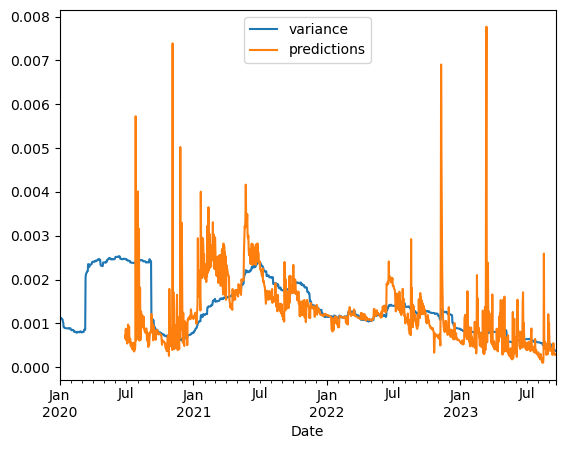

In [9]:
# To see how close the predictions are

daily_df[['variance','predictions']].plot()

# 3. Calculate prediction premium and form a daily signal from it  

We are calculating the prediction premium and calculate it's 6-month rolling standard deviation  
From this we are creating our daily signal

In [17]:
daily_df['prediction_premium'] = (daily_df['predictions'] - daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()



In [15]:
# daily_df = daily_df.drop('prediction_premium', axis=1)

In [18]:
daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std
Date,,,,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,0.000914,0.001125,NaN,NaN,NaN
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,-0.030273,0.001127,NaN,NaN,NaN
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,0.050172,0.001139,NaN,NaN,NaN
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,0.008915,0.001110,NaN,NaN,NaN
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,0.000089,0.001106,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.544319
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240810,0.541657
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.540672


<Axes: xlabel='Date'>

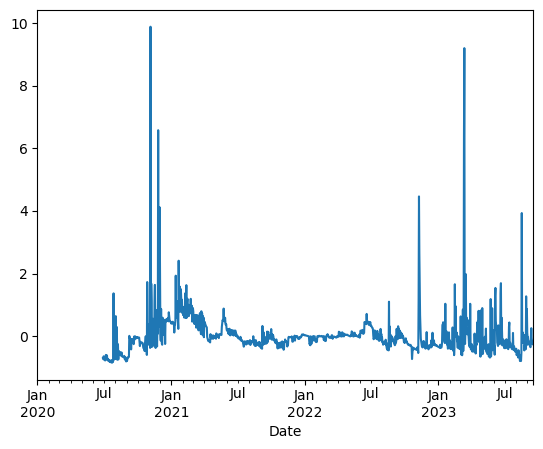

In [19]:
daily_df['prediction_premium'].plot()

<Axes: xlabel='Date'>

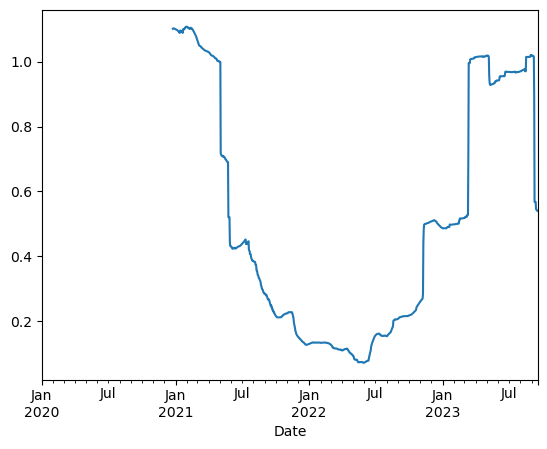

In [20]:
daily_df['premium_std'].plot()

In [21]:
# Creating our daily signal

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std']*1.5)
                                          else (-1 if (x['prediction_premium']<x['premium_std']*-1.5) else np.nan),
                                          axis=1)

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,0.000914,0.001125,NaN,NaN,NaN,NaN
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,-0.030273,0.001127,NaN,NaN,NaN,NaN
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,0.050172,0.001139,NaN,NaN,NaN,NaN
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,0.008915,0.001110,NaN,NaN,NaN,NaN
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,0.000089,0.001106,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.544319,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240810,0.541657,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.540672,NaN


In [22]:
# To see rows where our daily signal is 1 (not NaN)

daily_df[daily_df['signal_daily']==1]

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2021-01-13,8478.780273,9399.990234,8146.166992,9329.089844,9329.089844,6.936432e+10,0.095340,0.001004,0.002943,1.930519,1.096322,1.0
2021-01-21,8887.349609,8888.169922,7562.687500,7706.424805,7706.424805,7.564307e+10,-0.142528,0.001174,0.004003,2.408844,1.100363,1.0
2022-05-09,8515.003906,8555.518555,7574.238281,7574.238281,7574.238281,6.335549e+10,-0.117055,0.001151,0.001326,0.151904,0.080462,1.0
2022-05-10,7568.413574,8149.077148,7486.200684,7755.726563,7755.726563,5.981104e+10,0.023679,0.001156,0.001316,0.139212,0.080613,1.0
2022-05-11,7754.045898,8003.350586,7042.603516,7234.088867,7234.088867,7.038886e+10,-0.069627,0.001179,0.001325,0.123665,0.080412,1.0
2022-05-17,7465.602051,7673.622559,7392.575684,7606.464355,7606.464355,2.910147e+10,0.018675,0.001172,0.001300,0.109646,0.072962,1.0
2022-06-02,7448.722656,7651.183594,7413.176270,7616.872070,7616.872070,2.908356e+10,0.022183,0.001177,0.001381,0.173229,0.072658,1.0
2022-06-03,7616.951660,7658.258789,7343.922363,7426.097656,7426.097656,2.617555e+10,-0.025365,0.001180,0.001386,0.174924,0.073286,1.0
2022-06-04,7426.534668,7482.641113,7375.001465,7458.228516,7458.228516,1.658837e+10,0.004317,0.001176,0.001317,0.119932,0.073912,1.0


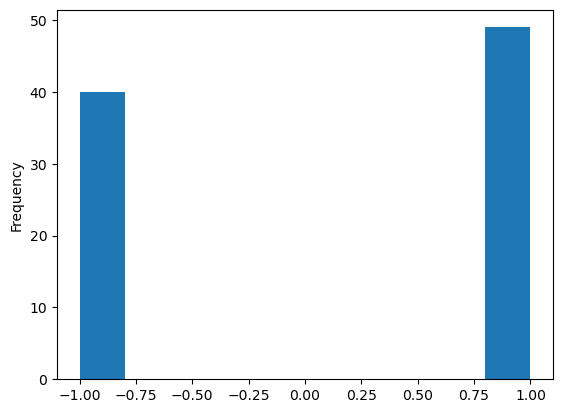

In [23]:
daily_df['signal_daily'].plot(kind='hist')

plt.show()

In [24]:
# We need to shift the daily data by one day as we will be using the data next day

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-01-01,1798.723022,1813.582642,1793.736084,1800.043579,1800.043579,1.856566e+10,0.000914,0.001125,NaN,NaN,NaN,NaN
2020-01-02,1800.637817,1803.038818,1733.817505,1746.367554,1746.367554,2.080208e+10,-0.030273,0.001127,NaN,NaN,NaN,NaN
2020-01-03,1746.107178,1853.428833,1728.749023,1836.221069,1836.221069,2.811148e+10,0.050172,0.001139,NaN,NaN,NaN,NaN
2020-01-04,1836.343872,1856.846436,1827.378540,1852.664185,1852.664185,1.844427e+10,0.008915,0.001110,NaN,NaN,NaN,NaN
2020-01-05,1852.612915,1886.124268,1850.133911,1852.829346,1852.829346,1.972507e+10,0.000089,0.001106,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.544319,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240810,0.541657,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.540672,NaN


In [25]:
daily_df[daily_df['signal_daily']==1]

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2021-01-14,9331.277344,9991.601563,9217.140625,9796.832031,9796.832031,6.361599e+10,0.048922,0.001013,0.001608,0.586445,1.095142,1.0
2021-01-22,7704.406250,8452.962891,7238.343262,8251.440430,8251.440430,7.720727e+10,0.068333,0.001194,0.002611,1.186358,1.101009,1.0
2022-05-10,7568.413574,8149.077148,7486.200684,7755.726563,7755.726563,5.981104e+10,0.023679,0.001156,0.001316,0.139212,0.080613,1.0
2022-05-11,7754.045898,8003.350586,7042.603516,7234.088867,7234.088867,7.038886e+10,-0.069627,0.001179,0.001325,0.123665,0.080412,1.0
2022-05-12,7234.183594,7508.109863,6587.622559,7261.937988,7261.937988,6.698917e+10,0.003842,0.001179,0.001224,0.038031,0.079482,1.0
2022-05-18,7606.119629,7654.679199,7180.067871,7180.067871,7180.067871,3.128527e+10,-0.057690,0.001185,0.001239,0.046016,0.073092,1.0
2022-06-03,7616.951660,7658.258789,7343.922363,7426.097656,7426.097656,2.617555e+10,-0.025365,0.001180,0.001386,0.174924,0.073286,1.0
2022-06-04,7426.534668,7482.641113,7375.001465,7458.228516,7458.228516,1.658837e+10,0.004317,0.001176,0.001317,0.119932,0.073912,1.0
2022-06-05,7458.779297,7529.436035,7393.612305,7476.665527,7476.665527,1.726409e+10,0.002469,0.001176,0.001296,0.102179,0.074368,1.0


# 4. Merge with intraday data and calculate intraday indicators to form the intraday signal  

Calculate all intraday indicators and intraday signal

In [26]:
intraday_5min_df

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


In [28]:
intraday_5min_df.reset_index()\
.merge(daily_df[['signal_daily']].reset_index(),
       left_on='date',
       right_on='Date')\
.set_index('datetime')

,open,low,high,close,volume,date,Date,signal_daily
datetime,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29,2021-09-29,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29,2021-09-29,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29,2021-09-29,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29,2021-09-29,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29,2021-09-29,NaN
...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,2023-09-18,2023-09-18,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,2023-09-18,2023-09-18,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,2023-09-18,2023-09-18,NaN


In [29]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .set_index('datetime')

final_df

,open,low,high,close,volume,date,Date,signal_daily
datetime,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29,2021-09-29,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29,2021-09-29,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29,2021-09-29,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29,2021-09-29,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29,2021-09-29,NaN
...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,2023-09-18,2023-09-18,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,2023-09-18,2023-09-18,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,2023-09-18,2023-09-18,NaN


In [30]:
final_df = final_df.drop(['date', 'Date'], axis=1)

final_df

,open,low,high,close,volume,signal_daily
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN
...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN


In [31]:
# import pandas_ta

In [32]:
final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

# Calculating the bollinger bounds

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                      length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df

,open,low,high,close,volume,signal_daily,rsi,lband,uband
datetime,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084


In [33]:
# Buy signal is when the momentum is upwards i.e. RSI > 70 and the close price is higher than the upper bollinger bound
# Sell signal is when RSI < 30 and close price is lower than the lower bollinger bound
# This is a pure momentum pattern used by the auther of this course

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                          (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday
datetime,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN


In [42]:
final_df[final_df['signal_daily']==1]

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday
datetime,,,,,,,,,,
2022-05-10 00:00:00,7659.7450,7648.6225,7701.25,7681.7225,304,1.0,46.591413,7621.924477,7849.594523,NaN
2022-05-10 00:05:00,7681.7675,7667.1425,7738.75,7718.0075,224,1.0,50.426720,7624.152156,7836.581844,NaN
2022-05-10 00:10:00,7718.0125,7688.9975,7735.50,7695.4875,158,1.0,48.166992,7621.314296,7831.234454,NaN
2022-05-10 00:15:00,7695.6400,7694.9600,7760.00,7736.2900,163,1.0,52.248124,7625.368672,7819.319828,NaN
2022-05-10 00:20:00,7736.3175,7726.6575,7775.50,7729.4725,153,1.0,51.534471,7636.048532,7797.587218,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-08-18 23:35:00,6490.1975,6487.5300,6496.75,6488.1950,18,1.0,40.177886,6480.544660,6515.634090,NaN
2023-08-18 23:40:00,6488.1925,6483.7825,6492.75,6485.6775,11,1.0,38.794795,6479.144122,6514.973628,NaN
2023-08-18 23:45:00,6485.8500,6482.7100,6492.25,6485.3125,20,1.0,38.592045,6477.817948,6514.410802,NaN


# 5. Generate the position entry and hold untill the end of the day

In [43]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                         else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                               axis=1)

final_df

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return_sign
datetime,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN,NaN


In [46]:
final_df[final_df['return_sign']==1]

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return_sign
datetime,,,,,,,,,,,
2021-10-20 16:25:00,16453.7750,16422.2775,16490.2500,16422.2775,183,-1.0,28.612648,16446.656872,16726.321628,-1.0,1.0
2021-10-20 21:50:00,16308.4050,16237.5000,16318.6750,16255.2650,340,-1.0,25.844043,16288.575674,16496.577807,-1.0,1.0
2021-10-20 21:55:00,16255.0425,16159.2825,16282.2500,16246.7350,564,-1.0,25.220144,16263.826209,16501.461522,-1.0,1.0
2021-10-20 22:00:00,16246.7350,16011.7250,16295.5000,16118.1400,870,-1.0,18.234580,16203.703409,16530.324822,-1.0,1.0
2021-10-22 09:55:00,15682.2500,15580.9825,15691.8200,15598.7500,375,-1.0,28.486815,15680.844114,15984.197886,-1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-07 23:20:00,4896.8725,4886.0550,4936.2500,4916.5400,591,-1.0,21.176814,4923.148176,5209.689574,-1.0,1.0
2022-11-08 13:05:00,4828.2500,4686.7500,4839.2500,4728.0125,3475,-1.0,29.353844,4766.165884,5226.355366,-1.0,1.0
2022-11-08 13:15:00,4757.0200,4659.0000,4761.5000,4673.2925,1865,-1.0,28.555002,4689.338251,5218.722749,-1.0,1.0


In [49]:
# Hold until end of the day for long terms i.e. return_sign = 1
# return_sign = -1 is short term

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

# final_df[final_df['return_sign']==1]

In [50]:
final_df[final_df['return_sign']==1]

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return_sign
datetime,,,,,,,,,,,
2021-10-20 16:25:00,16453.7750,16422.2775,16490.2500,16422.2775,183,-1.0,28.612648,16446.656872,16726.321628,-1.0,1.0
2021-10-20 16:30:00,16422.4050,16400.0000,16451.2550,16449.7500,213,-1.0,33.557469,16427.158587,16727.907663,NaN,1.0
2021-10-20 16:35:00,16449.7500,16441.7175,16485.3500,16459.5075,126,-1.0,35.234684,16414.101192,16720.462308,NaN,1.0
2021-10-20 16:40:00,16461.2075,16433.8425,16482.3975,16437.1800,77,-1.0,33.215126,16399.884448,16711.608052,NaN,1.0
2021-10-20 16:45:00,16437.0800,16436.2925,16491.0000,16459.5900,99,-1.0,37.028489,16391.948851,16699.773649,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-08 23:35:00,4596.0000,4570.0500,4602.5000,4570.0500,5,-1.0,49.005009,4512.671542,4605.048458,NaN,1.0
2022-11-08 23:40:00,4581.5000,4560.2000,4581.5000,4560.2000,7,-1.0,47.178936,4515.742826,4604.789674,NaN,1.0
2022-11-08 23:45:00,4560.2750,4553.4250,4572.2500,4561.7500,103,-1.0,47.502965,4517.738395,4604.919105,NaN,1.0


In [51]:
final_df['return'] = final_df['close'].pct_change()

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

final_df

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return_sign,return,forward_return,strategy_return
datetime,,,,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,NaN,0.000018,0.001270,NaN
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,NaN,0.001270,0.005605,NaN
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,NaN,0.005605,-0.000146,NaN
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,NaN,-0.000146,-0.000813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN,NaN,0.000128,0.000070,NaN
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN,NaN,0.000070,-0.000158,NaN
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN,NaN,-0.000158,-0.000368,NaN


In [52]:
# To get the daily level strategy return

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))[['strategy_return']].sum()

daily_return_df

,strategy_return
datetime,
2021-09-29,0.0
2021-09-30,0.0
2021-10-01,0.0
2021-10-02,0.0
2021-10-03,0.0
...,...
2023-09-14,0.0
2023-09-15,0.0
2023-09-16,0.0


# 6. Calculate final strategy returns

In [54]:
# import matplotlib.ticker as mtick

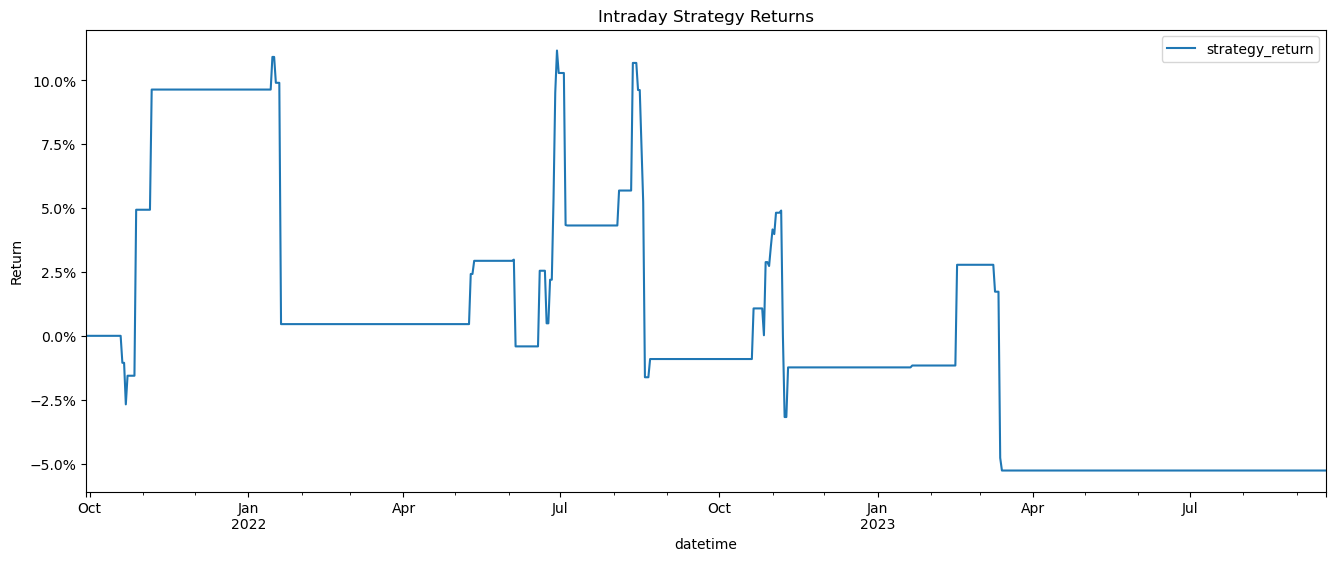

In [55]:
strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()